# Final Models Notebook

The below notebook represents a compiled version of our 'best-estimators' for each model run with both the training and test set. Both results and confusion matrices are produced for each all-star model, which are discussed in further detail in the paper. The notebook also implements a function that tracks the time and CPU use for each model to run inference on the train and test sets. These results alongside the accuracy are printed in a dataframe at the bottom of the notebook, which informs which models we thought were best in terms of bang for your buck (balancing compute and accuracy) and most accurate, regardless of the resources it took. 

To see how we arrived for the parameters used when instantiating each model, please see its corresponding cross-validation notebook in this repository.

In [1]:
import psutil
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Data Import

In [2]:
# import training set
train_df = pd.read_pickle('/Users/erin/Documents/comp-viz/final-project/fabric/pkls/train_0406_scalar_non-aug.pkl')
X_train = train_df.iloc[:,2:]
y_train = train_df.iloc[:,0]

# import test set
test_df = pd.read_pickle('/Users/erin/Documents/comp-viz/final-project/fabric/pkls/test_0415.pkl')
X_test = test_df.iloc[:,2:]
y_test = test_df.iloc[:,0]

# Apply SMOTE to the training data for model requiring balanced dataset
smote = SMOTE(random_state=23)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Helper Functions

In [3]:
def plot_confusion(y_predicted, y_actual):
    """Function to plot a normalized confusion matrix
    based on model predictions

    Args:
        y_predicted (pd series): model category predictions
        y_actual (pd series): actual categories

    Returns:
        confusion matrix plot: image of the confusion matrix
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_actual, y_predicted)

    # Normalize the confusion matrix by row (i.e., by the number of samples in each actual class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    class_names = ['Blended', 'Denim', 'Polyester', 'Cotton', 'Wool']

    # Plot normalized confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as necessary
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)

    # To display percentage values in the plot, you need to enable include_values=True and adjust the formatting accordingly
    disp.plot(include_values=True, cmap='viridis', ax=ax, xticks_rotation='vertical', values_format=".2%")  # values_format controls the numeric format

    plt.title('Normalized Confusion Matrix')
    return plt.show()

def accuracy_metrics(y_pred_train, y_train, y_pred_test, y_test):
    """Function pulling train and test accuracy metrics

    Args:
        y_pred_train (pd.Series): category predictions for training set
        y_train (pd.Series): actual categories training set
        y_pred_test (pd.Series): category predictions for test set
        y_test (pd.Series): actual categories test set

    Returns:
        train_accuracy: model accuracy for training set as a float
        test_accuracy: model accuracy for test set as a float
    """

    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    return train_accuracy, test_accuracy

# Function to measure memory and CPU usage
def measure_usage():
    # Memory usage in percentage
    memory_use_percent = psutil.virtual_memory().percent
    # CPU usage in percentage
    cpu_use_percent = psutil.cpu_percent(interval=1)
    return memory_use_percent, cpu_use_percent

In [4]:
def fit_eval_final_model(instantiated_model, X_train, y_train, X_test, y_test):
    """This function takes in an instantiated model for fitting plus train
    and test data so as to run inference, report predictions, and return
    cost in terms of CPU usage and time.

    Args:
        instantiated_model (sklearn object): model or pipeline object with 'fit' method
        X_train (pandas df): dataframe or array - X design matrix (features) for training set
        y_train (pandas series): numerically represented categorical series for training set
        X_test (pandas df): dataframe or array - X design matrix (features) for test set
        y_test (pandas series): numerically represented categorical series for test set

    Returns:
        resource_util: a dictionary containing statistics on model computational efficiency + accuracy
    """
    
    mem_before, cpu_before = measure_usage()
    start_time = time.time()
    
    # TRAIN
    instantiated_model.fit(X_train, y_train)

    # After training
    training_time = time.time() - start_time
    mem_after_train, cpu_after_train = measure_usage()

    # INFERENCE - TEST
    start_time = time.time()
    test_predictions = instantiated_model.predict(X_test)

    # After inference
    inference_time = time.time() - start_time
    mem_after_inference, cpu_after_inference = measure_usage()


    # INFERENCE - TRAIN
    train_predictions = instantiated_model.predict(X_train)

    # Store resource utilization in dictionary
    resource_util = {}
    resource_util['mem_pre_train'] = mem_before
    resource_util['cpu_pre_train'] = cpu_before
    resource_util['mem_post_train'] = mem_after_train
    resource_util['cpu_post_train'] = cpu_after_train
    resource_util['mem_post_inference'] = mem_after_inference
    resource_util['cpu_post_inference'] = cpu_after_inference
    resource_util['training_time'] = training_time
    resource_util['inference_time'] = inference_time

    # PLOT CONFUSION - TRAIN
    plot_confusion(train_predictions, y_train)

    # PLOT CONFUSION - TEST
    plot_confusion(test_predictions, y_test)

    # ACCURACY
    train_accuracy, test_accuracy = accuracy_metrics(train_predictions, y_train, test_predictions, y_test)

    resource_util['train_accuracy'] = train_accuracy
    resource_util['test_accuracy'] = test_accuracy

    # Evaluate the model - train
    print("Accuracy on Training Set: {:.2f}%".format(train_accuracy * 100))
    print("\nClassification Report - Training:\n", classification_report(y_train, train_predictions))

    # Evaluate the model - test
    print("Accuracy on Test Set: {:.2f}%".format(test_accuracy * 100))
    print("\nClassification Report - Test:\n", classification_report(y_test, test_predictions))

    return resource_util
    

# Support Vector Machine

Below is the svm model. This model is implemented using the optimal parameters as produced by the GridSearchCV and uses a pipeline to scale input data (which is not required for XGBoost or Random Forest).

In [12]:
best_params = {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

svm_pipeline_final = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('svm', SVC(C=best_params['svm__C'], kernel=best_params['svm__kernel'], gamma=best_params['svm__gamma'], probability=True))
])

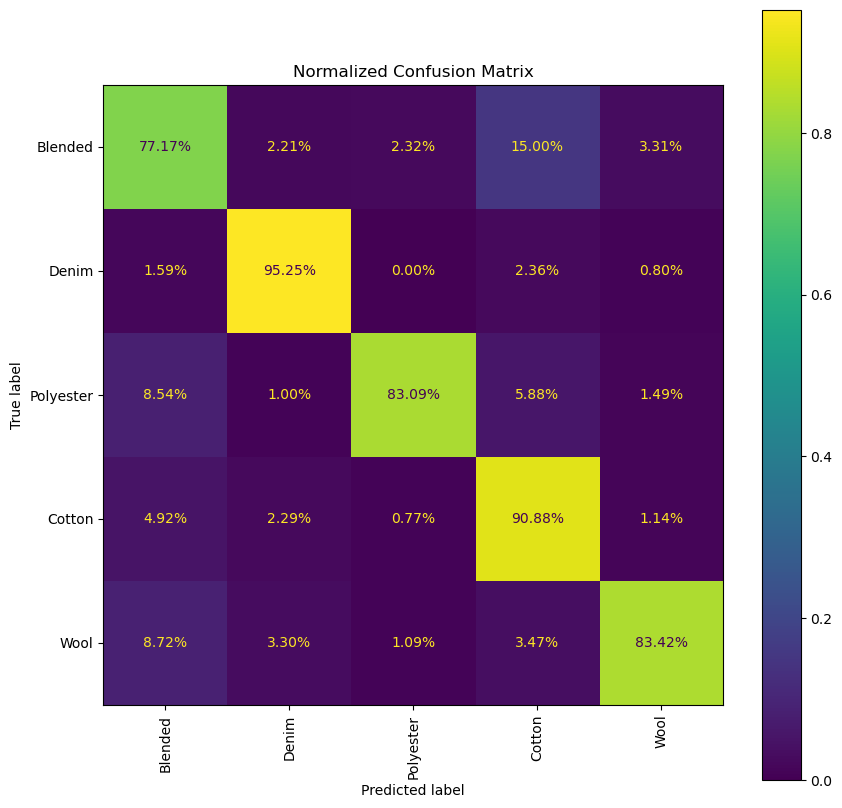

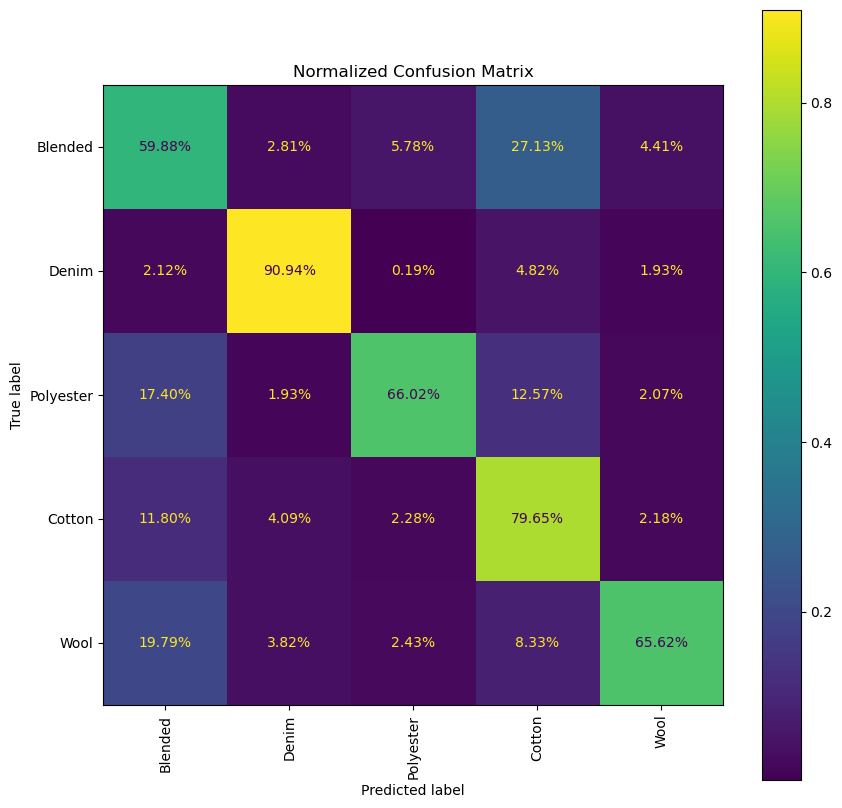

Accuracy on Training Set: 86.65%

Classification Report - Training:
               precision    recall  f1-score   support

           0       0.82      0.77      0.80      5260
           1       0.91      0.95      0.93      4146
           2       0.92      0.83      0.87      2892
           3       0.86      0.91      0.88      7526
           4       0.85      0.83      0.84      2304

    accuracy                           0.87     22128
   macro avg       0.87      0.86      0.86     22128
weighted avg       0.87      0.87      0.87     22128

Accuracy on Test Set: 72.45%

Classification Report - Test:
               precision    recall  f1-score   support

           0       0.65      0.60      0.63      1316
           1       0.77      0.91      0.84       519
           2       0.79      0.66      0.72       724
           3       0.75      0.80      0.77      1882
           4       0.60      0.66      0.63       288

    accuracy                           0.72      4729
 

In [13]:
svm_resource_util = fit_eval_final_model(svm_pipeline_final, X_train, y_train, X_test, y_test)

# Standard RF

Below is the random forest model which does not balance for imbalances. This model is implemented using the optimal parameters as produced by the GridSearchCV.

In [10]:
rf_model_final = RandomForestClassifier(
    n_estimators=300,             # Number of trees in the forest
    max_depth=30,               # Maximum depth of each tree
    min_samples_split=2,          # Minimum number of samples required to split an internal node
    max_features='sqrt',          # Number of features to consider when looking for the best split
    random_state=23               # Seed used by the random number generator for reproducibility
)

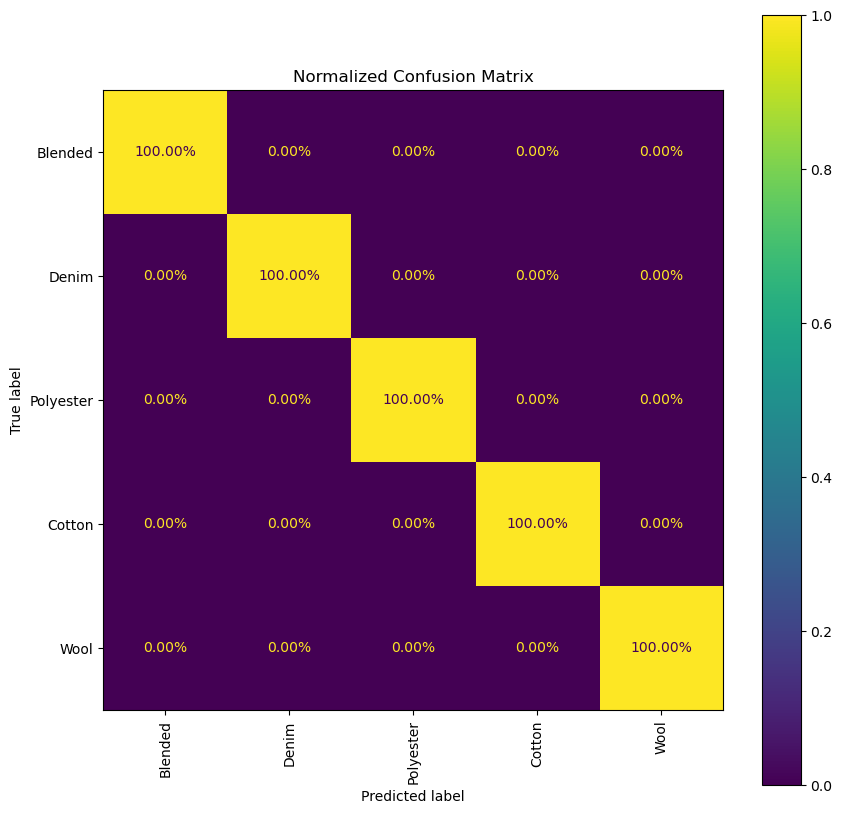

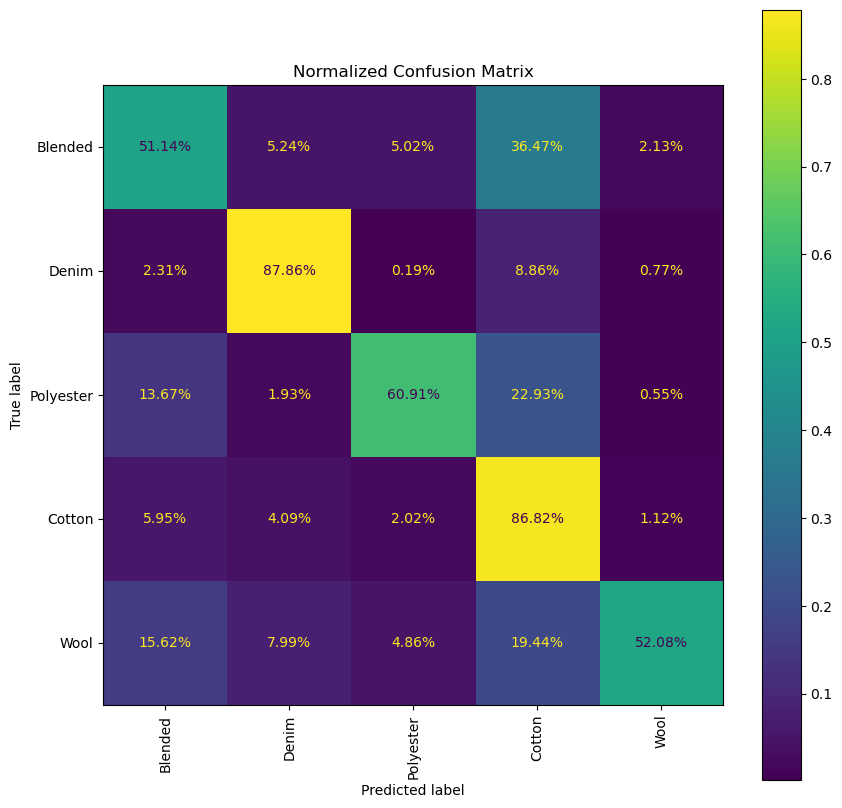

Accuracy on Training Set: 100.00%

Classification Report - Training:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5260
           1       1.00      1.00      1.00      4146
           2       1.00      1.00      1.00      2892
           3       1.00      1.00      1.00      7526
           4       1.00      1.00      1.00      2304

    accuracy                           1.00     22128
   macro avg       1.00      1.00      1.00     22128
weighted avg       1.00      1.00      1.00     22128

Accuracy on Test Set: 70.92%

Classification Report - Test:
               precision    recall  f1-score   support

           0       0.72      0.51      0.60      1316
           1       0.71      0.88      0.79       519
           2       0.79      0.61      0.69       724
           3       0.69      0.87      0.77      1882
           4       0.72      0.52      0.61       288

    accuracy                           0.71      4729


In [11]:
rf_resource_util = fit_eval_final_model(rf_model_final, X_train, y_train, X_test, y_test)

# Weighted RF

Below is the weighted random forest model which accounts for imbalanced classes with class_weight='balanced_subsample'. This model is implemented using the optimal parameters as produced by the GridSearchCV.

In [8]:
# Instantiate model based on reported results from gridsearch

rf_model_weighted_final = RandomForestClassifier(
    n_estimators=200,             # Number of trees in the forest
    max_depth=None,               # Maximum depth of each tree
    min_samples_split=5,          # Minimum number of samples required to split an internal node
    max_features='sqrt',          # Number of features to consider when looking for the best split
    class_weight='balanced_subsample',  # Weights associated with classes based on the y values
    random_state=23               # Seed used by the random number generator for reproducibility
)

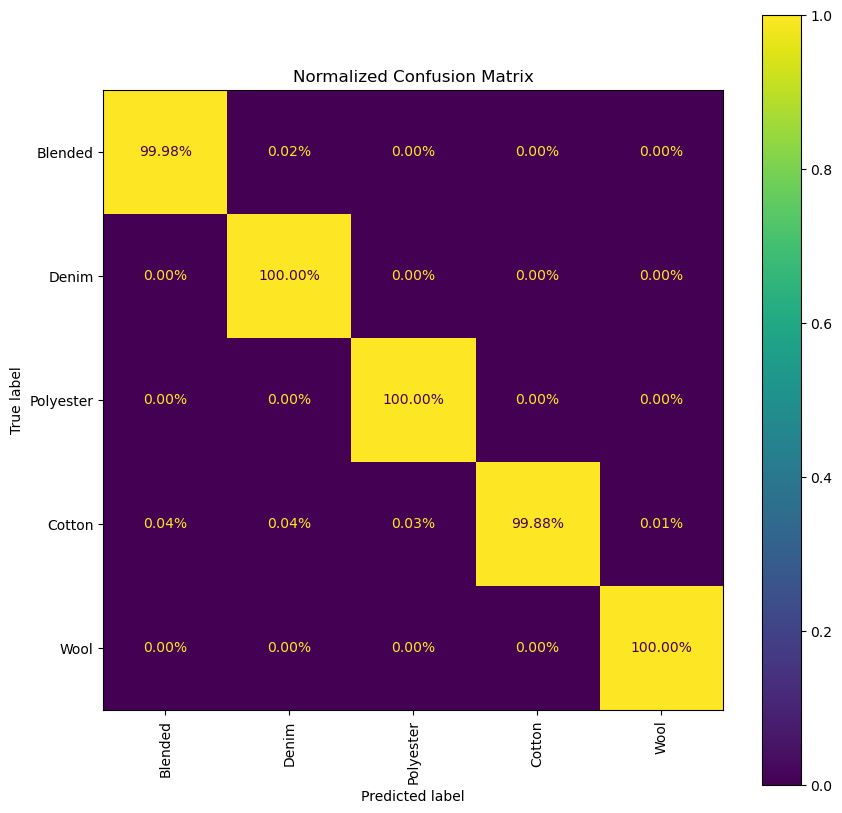

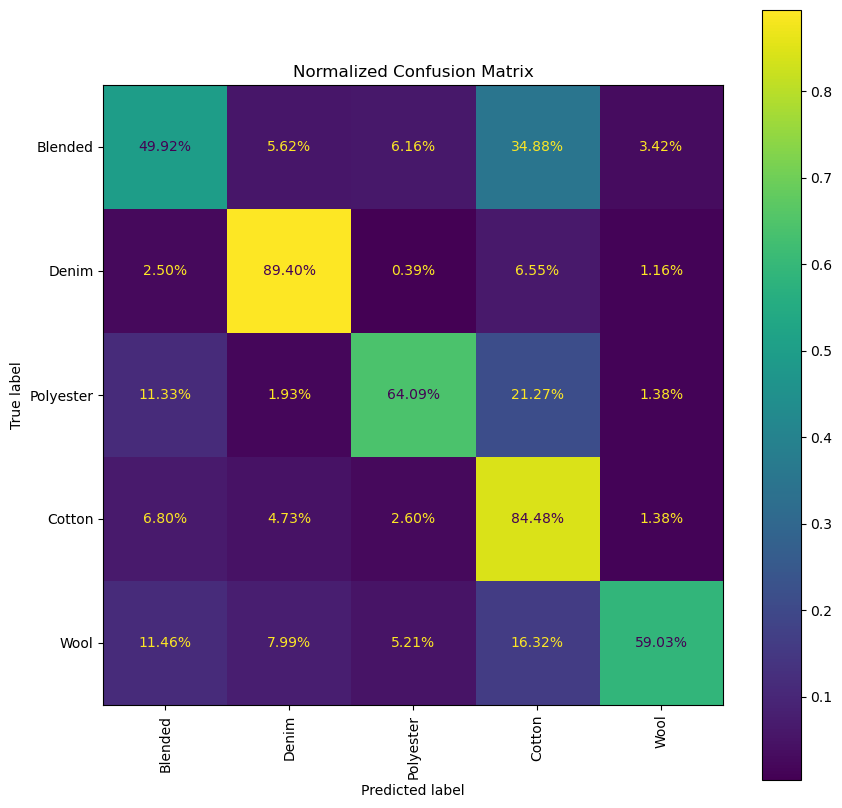

Accuracy on Training Set: 99.95%

Classification Report - Training:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5260
           1       1.00      1.00      1.00      4146
           2       1.00      1.00      1.00      2892
           3       1.00      1.00      1.00      7526
           4       1.00      1.00      1.00      2304

    accuracy                           1.00     22128
   macro avg       1.00      1.00      1.00     22128
weighted avg       1.00      1.00      1.00     22128

Accuracy on Test Set: 70.73%

Classification Report - Test:
               precision    recall  f1-score   support

           0       0.72      0.50      0.59      1316
           1       0.70      0.89      0.78       519
           2       0.76      0.64      0.70       724
           3       0.70      0.84      0.76      1882
           4       0.66      0.59      0.62       288

    accuracy                           0.71      4729
 

In [9]:
rf_w_resource_util = fit_eval_final_model(rf_model_weighted_final, X_train, y_train, X_test, y_test)

# XGBoost

Below is the gradient boost model which accounts for imbalanced classes via the use of SMOTE to balance training data (see earlier in notebook). This model is implemented using the optimal parameters as produced by the GridSearchCV.

In [5]:
# Setup the model with the best parameters from grid search
xgb_final_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.2,
    max_depth=9,
    min_child_weight=1,
    subsample=1.0,
    colsample_bytree=0.7,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=23
)

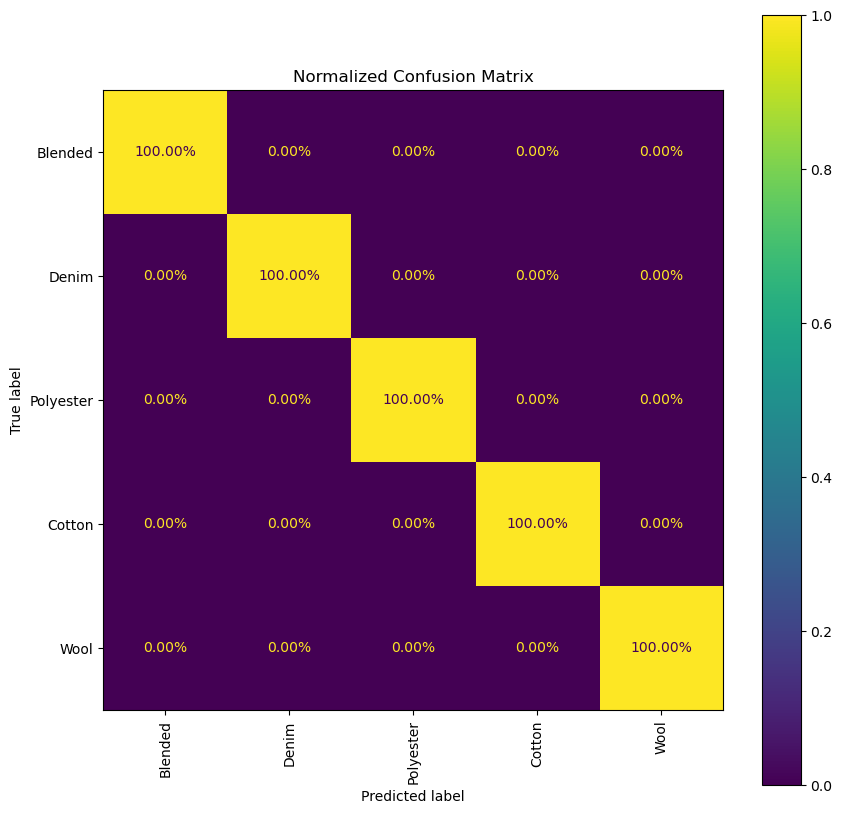

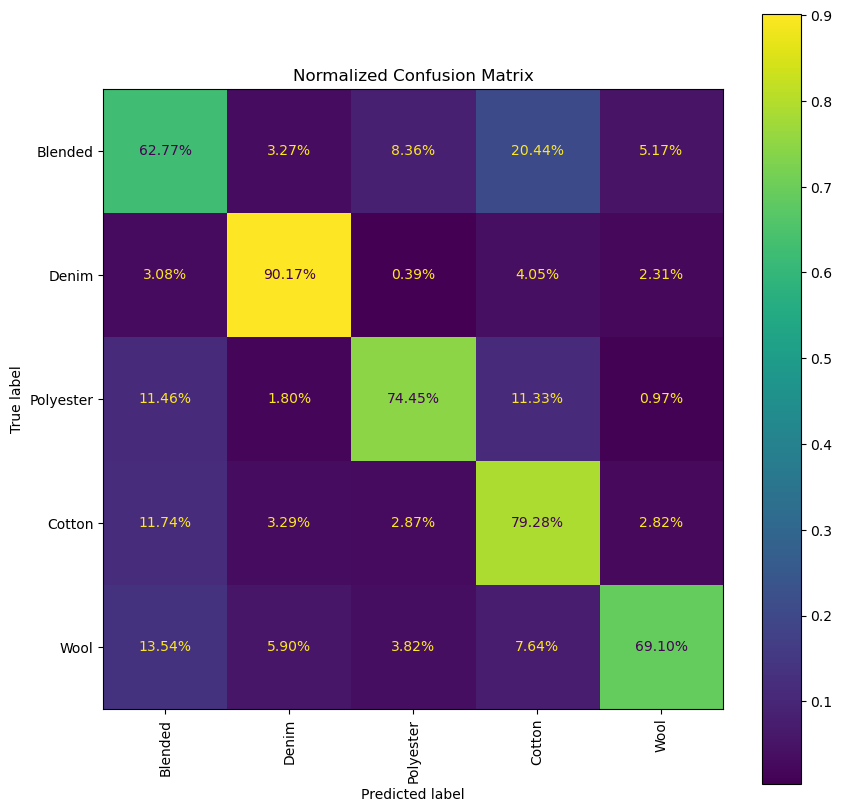

Accuracy on Training Set: 100.00%

Classification Report - Training:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7526
           1       1.00      1.00      1.00      7526
           2       1.00      1.00      1.00      7526
           3       1.00      1.00      1.00      7526
           4       1.00      1.00      1.00      7526

    accuracy                           1.00     37630
   macro avg       1.00      1.00      1.00     37630
weighted avg       1.00      1.00      1.00     37630

Accuracy on Test Set: 74.52%

Classification Report - Test:
               precision    recall  f1-score   support

           0       0.70      0.63      0.66      1316
           1       0.78      0.90      0.83       519
           2       0.75      0.74      0.75       724
           3       0.79      0.79      0.79      1882
           4       0.59      0.69      0.63       288

    accuracy                           0.75      4729


In [7]:
xgb_resource_util = fit_eval_final_model(xgb_final_model, X_train_balanced, y_train_balanced, X_test, y_test)

# Comparison Matrix

In [15]:
comparison_dict = [
    svm_resource_util,
    rf_resource_util,
    rf_w_resource_util,
    xgb_resource_util
]

model_names = ['svm', 'random_forest', 'weighted_random_forest', 'xgb']

comp_df = pd.DataFrame(comparison_dict)
comp_df.insert(0, 'Model', model_names)

comp_df.head(4)

,Model,mem_pre_train,cpu_pre_train,mem_post_train,cpu_post_train,mem_post_inference,cpu_post_inference,training_time,inference_time,train_accuracy,test_accuracy
0,svm,63.7,11.4,63.8,12.5,64.3,13.8,54.163419,4.110906,0.866459,0.724466
1,random_forest,62.9,11.3,62.9,12.6,63.2,11.9,22.108091,0.220572,1.000000,0.709241
2,weighted_random_forest,62.8,14.4,63.5,12.5,63.4,12.4,15.426533,0.142592,0.999548,0.707338
3,xgb,61.8,9.2,61.3,24.8,61.3,31.5,6.345778,0.042066,1.000000,0.745189
